In [44]:
library(readr)
library(tidyr)
library(dplyr)
library(stringr)
library(lubridate)

In [78]:
fp <- '/pool001/mfzhao/'
#policy <- read_csv(str_c(fp, 'policy/county_policy_long.csv'))
CUSP   <- read_csv(str_c(fp, 'policy/CUSP_policy.csv'))
fips   <- read_csv(str_c(fp, 'geo_data/county_fips_master.csv'))

Parsed with column specification:
cols(
  State = col_character(),
  closeSchools = col_character(),
  closeDaycares = col_character(),
  closeNursing = col_character(),
  closeBusiness = col_character(),
  closeRestaurants = col_character(),
  closeGyms = col_character(),
  closeMovies = col_character(),
  stayHome = col_character(),
  endStayHome = col_character(),
  reopenBusiness = col_character(),
  reopenRestaurants = col_character(),
  reopenGyms = col_character(),
  reopenMovies = col_character(),
  resumeElective = col_character()
)

Parsed with column specification:
cols(
  fips = col_double(),
  county_name = col_character(),
  state_abbr = col_character(),
  state_name = col_character(),
  long_name = col_character(),
  sumlev = col_double(),
  region = col_double(),
  division = col_double(),
  state = col_double(),
  county = col_double(),
  crosswalk = col_character(),
  region_name = col_character(),
  division_name = col_character()
)



In [79]:
fips %>%
    mutate(key = str_pad(fips, 5, pad = '0')) %>%
    select(key, county_name, state_abbr, state_name) %>%
    distinct() -> fips

#policy %>% 
#    spread(key = type, value = dt) %>% 
#    rowwise() %>%
#    mutate(p1sdp = min(gatherings50, gatherings500, gyms_movies, restaurants, schools, na.rm = T),
#           key = str_pad(fips, 5, pad = '0')) %>%
#    select(key, p1sdp, p2shp = stay_home, state_abbv) -> policy

In [86]:
CUSP %>%
    rowwise() %>%
    mutate(p1sdp = min(closeSchools, closeDaycares, closeNursing, closeBusiness, closeRestaurants, closeGyms, closeMovies, na.rm = T),
           p3rop = min(endStayHome, reopenBusiness, na.rm = T)) %>%
    rename(p2shp = stayHome) %>%
    select(state_name = State, p1sdp, p2shp, p3rop) %>%
    mutate_at(vars(-state_name), mdy) %>%
    inner_join(fips) %>% 
    select(key, p1sdp, p2shp, p3rop) -> policyPeriods

write_csv(policyPeriods, str_c(fp, 'PROCESSED_DATA/policyPeriods.csv'))

Joining, by = "state_name"



In [87]:
expand.grid(key = policyPeriods$key, 
            date = seq.Date(as.Date('2020-01-01'), as.Date('2020-06-30'), 'day'), 
            stringsAsFactors = F) %>%
    left_join(policyPeriods %>%
              gather(key = 'period', value = 'date', -key) %>%
              mutate(value = 1) %>%
              spread(key = period, value = value)) %>%
    arrange(key, date) %>%
    group_by(key) %>%
    fill(p1sdp, p2shp, p3rop) %>%
    replace_na(list(p1sdp = 0, p2shp = 0, p3rop = 0)) -> policy


Joining, by = c("key", "date")



In [88]:
policy %>%
    left_join(policyPeriods %>%
                 rename(p1start = p1sdp, 
                        p2start = p2shp,
                        p3start = p3rop)) %>%
    mutate(p1sdpDSS = as.numeric(date - p1start) * as.numeric(p1sdp == 1 & (p2shp != 1 | p3rop != 1)), 
           p2shpDSS = as.numeric(date - p2start) * as.numeric(p2shp ==1 & p3rop != 1),
           p3ropDSS = as.numeric(date - p3start) * p3rop) %>%
    replace_na(list(p2shpDSS = 0)) %>%
    select(-p1start, -p2start, -p3start) -> policy

Joining, by = "key"



In [89]:
write_csv(policy, str_c(fp, 'PROCESSED_DATA/policy.csv'))

In [42]:
df <- read_csv(str_c(fp, 'PROCESSED_DATA/policyPeriods.csv'))

Parsed with column specification:
cols(
  key = col_character(),
  p1sdp = col_date(format = ""),
  p2shp = col_date(format = ""),
  p3rop = col_date(format = "")
)



Warning message:
“Removed 490 rows containing non-finite values (stat_bin).”


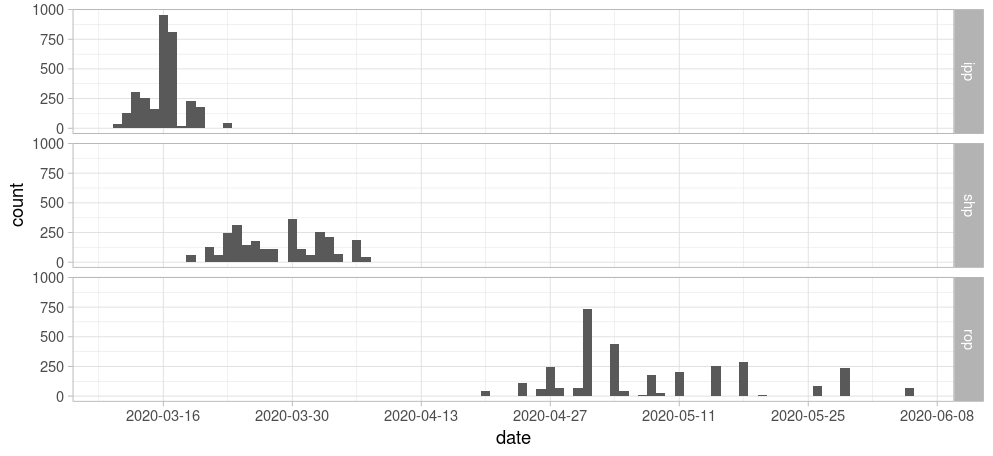

In [34]:
options(repr.plot.width=8.28, repr.plot.height=3.8)
df %>%
    rename(ipp = p1sdp, shp = p2shp, rop = p3rop) %>%
    gather(key = period, value = date, -key) %>%
    mutate(period = factor(period, levels = c('ipp', 'shp', 'rop'))) %>%
    ggplot(aes(x = date)) + 
    geom_histogram(binwidth = 1) + 
    facet_grid(period ~ .) + 
    scale_x_date(date_breaks = '2 weeks') + 
    theme_light()


In [8]:
library(ggplot2)

In [70]:
policyPeriods %>%
    select(key, p2shp) %>%
    mutate(state = str_sub(key, 1, 2)) %>%
    group_by(state, p2shp) %>%
    summarize(n = n()) %>%
    group_by(state) %>%
    mutate(p = n/sum(n)) %>%
    filter(p != 1)

Warning message:
“Grouping rowwise data frame strips rowwise nature”


state,p2shp,n,p
<chr>,<date>,<int>,<dbl>
01,2020-03-26,1,0.014925373
01,2020-04-04,66,0.985074627
02,2020-03-22,1,0.034482759
02,2020-03-28,28,0.965517241
06,2020-03-17,1,0.017241379
06,2020-03-19,57,0.982758621
08,2020-03-24,12,0.187500000
08,2020-03-26,52,0.812500000
12,2020-03-25,4,0.059701493


In [90]:
policy

key,date,p1sdp,p2shp,p3rop,p1sdpDSS,p2shpDSS,p3ropDSS
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001,2020-01-01,0,0,0,0,0,0
01001,2020-01-02,0,0,0,0,0,0
01001,2020-01-03,0,0,0,0,0,0
01001,2020-01-04,0,0,0,0,0,0
01001,2020-01-05,0,0,0,0,0,0
01001,2020-01-06,0,0,0,0,0,0
01001,2020-01-07,0,0,0,0,0,0
01001,2020-01-08,0,0,0,0,0,0
01001,2020-01-09,0,0,0,0,0,0
